In [1]:
from abc import abstractmethod, ABCMeta

from sklearn.datasets import make_classification, make_regression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import OneHotEncoder
from scipy.special import expit
from sklearn.model_selection import train_test_split

import numpy as np
import struct

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats. 
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the 
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter, 
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    
    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [3]:
class Activation(object):
    def __init__(self):
        pass
    
    @abstractmethod
    def call(self, X): pass
    @abstractmethod
    def derivative(self, X): pass
    
class ActivationSigmoid(Activation):
    def __init__(self):
        super().__init__()
        
    def call(self, X):
        return expit(X)
    
    def derivative(self, X):
        temp = self.call(X)
        return temp / (1 - temp)
    
class ActivationTanh(Activation):
    def __init__(self):
        super().__init__()
        
    def call(self, X):
        return np.tanh(X)
    
    def derivative(self, X):
        temp = np.tanh(X)
        return 1 - temp**2
    
class ActivationReLU(Activation):
    def __init__(self):
        super().__init__()
    
    def call(self, X):
        return (X > 0) * X
    
    def derivative(self, X):
        return (X > 0) * 1
    
class ActivationSoftMax(Activation):
    def __init__(self):
        super().__init__()
    
    def call(self, X):
        return softmax(X, axis=1)
    
    def derivative(self, X):
        pass
    
class ActivationLinear(Activation):
    def __init__(self):
        super().__init__()
    
    def call(self, X):
        return X
    
    def derivative(self, X):
        return 1
    
class ActivationLeakyReLU(Activation):
    def __init__(self, k):
        super().__init__()
        self.k = k
    
    def call(self, X):
        X = np.copy(X)
        X[X < 0] = -k * X
        X[X >= 0] = X
        return X
    
    def derivative(self, X):
        X = np.copy(X)
        X[X < 0] = -k
        X[X >= 0] = 1
        return X
    
class ActivationSoftPlus(Activation):
    def __init__(self):
        super().__init__()
    
    def call(self, X):
        return np.log(1 + np.exp(X))
    
    def derivative(self, X):
        return expit(X)

In [4]:
ST_TRAIN = 0
ST_INFERENCE = 1
class Layer(object): pass

class Layer(object):
    def __init__(self): 
        self.state = ST_TRAIN
    
    def set_state(self, state):
        self.state = state
    
    @abstractmethod
    def forward(self, X): pass
    
    @abstractmethod
    def backward(self, dZ, prev_layer: Layer = None): pass
    
    @abstractmethod
    def update(self, lr): pass


In [40]:
class FakeLayer(Layer): pass

class Dropout(FakeLayer):
    def __init__(self, proba=0.6):
        super().__init__()
        
        self.z = None
        self.neuron_mask = None
        self.proba = proba
        
    def forward(self, X):
        self.z = X
        
        if self.state == ST_TRAIN:
            self.neuron_mask = np.random.choice([0, 1], p=[self.proba, 1-self.proba], size=X.shape)
            return X * self.neuron_mask / (1-self.proba)
        
        elif self.state == ST_INFERENCE:
            return X  * (1-self.proba)  
        
    def backward(self, dZ, prev_layer: Layer = None):
        return dZ * self.neuron_mask
    
    def update(self, lr): pass

class InputLayer(FakeLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, X):
        self.z = X
        return self.z
        
    def backward(self, dZ, prev_layer: Layer = None):
        pass

In [6]:
class ActivationLayer(Layer):
    def __init__(self, activation_func: Activation):
        self.z = None
        self.dZ = None
        
        self._activation = activation_func
        
    def forward(self, X):
        self.z = self._activation.call(X)
        return self.z
        
    def backward(self, dZ = None, prev_layer: Layer = None):
        self.dZ = dZ
        return self.dZ * self._activation.derivative(prev_layer.z)

class ReLU(ActivationLayer):
    def __init__(self):
        super().__init__(ActivationReLU())

class LeakyReLU(ActivationLayer):
    def __init__(self):
        super().__init__(ActivationLeakyReLU())
        
class SoftPlus(ActivationLayer):
    def __init__(self):
        super().__init__(ActivationSoftPlus())
        
class Tanh(ActivationLayer):
    def __init__(self):
        super().__init__(ActivationTanh())
        
class Sigmoid(ActivationLayer):
    def __init__(self):
        super().__init__(ActivationSigmoid())
        
class SoftMaxCrossEntropy(ActivationLayer):
    # this layer should be only in the head
    
    def __init__(self):
        super().__init__(ActivationSoftMax())
        
    def backward(self, dZ, prev_layer: Layer = None):
        return self.z - dZ
    
class LinearMSE(ActivationLayer):
    # this layer should be only in the head

    def __init__(self):
        super().__init__(ActivationLinear())

    def backward(self, dZ, prev_layer: Layer = None):
        return self.z - dZ
        

class Dense(Layer):
    def __init__(self, n_neuron: int):
        self.z = None
        self.W = None
        self.b = None
        
        self.dZ = None
        self.dW = None
        self.dB = None
        
        self._input_size = None
        
        self.n_neuron = n_neuron
       
    def forward(self, X):
        if self.W is None:
            self.W = np.random.normal(size=(X.shape[1], self.n_neuron), loc=0, scale=1)
            self.b = np.random.normal(size=(1, self.n_neuron), loc=0, scale=1)
        
        self.z = X.dot(self.W) + self.b
        
        return self.z
    
    def backward(self, dZ, prev_layer: Layer = None):
        self.dZ = dZ
        self.dB = self.dZ.sum(0) / self.z.shape[0]

        self.dW = prev_layer.z.T @ self.dZ / self.z.shape[0]
        return self.dZ @ self.W.T
            
    def update(self, lr):
        self.W = self.W - self.dW * lr
        self.b = self.b - self.dB * lr


In [7]:
def cross_entropy_loss(y_real, y_pred):
    return -np.sum(np.log(y_pred) * y_real)

class NeuralNet(object):
    def __init__(self, epochs=1000, batch_size=128, loss='cross_entropy', metric='accuracy', lr=1.0, lr_decay_rate=3e-4):
        self.epochs = epochs
        self.lr = lr
        self.lr_decay_rate = lr_decay_rate
        self.loss = loss
        self.metric = metric
        self.batch_size = batch_size
        self._layers = list()
        self._encoder = None
        
        if self.metric == 'accuracy':
            self._metric_func = accuracy_score
        elif self.metric == 'mse':
            self._metric_func = mean_squared_error
            
        if self.loss == 'cross_entropy':
            self._loss_func = cross_entropy_loss
        elif self.loss == 'mse':
            self._loss_func = mean_squared_error
    
    def set_neurons_state(self, state):
        for layer in self._layers:
            layer.set_state(state)
    
    def add(self, layer: Dense):
        self._layers.append(layer)
        
    def exp_decay(self, initial_lrate, epoch):
        k = self.lr_decay_rate
        lrate = initial_lrate * np.exp(-k*epoch)
        return lrate
    
    def _forward(self, X):
        prev_output = X
        for layer in self._layers:
            prev_output = layer.forward(prev_output)
            
        return prev_output
        
    def _backward(self, X, y):
        dZ = y
        for ix_layer in reversed(range(len(self._layers))[1:]):
            dZ = self._layers[ix_layer].backward(dZ, prev_layer=self._layers[ix_layer-1])
    
    def _update(self, epoch):
        for layer in self._layers:
            layer.update(self.exp_decay(self.lr, epoch))
    
    def fit(self, X, y=None):
        history = {'loss': list(), 'metric': list()}
        y_cached = np.copy(y)
        
        if self._layers[-1].__class__.__name__ == 'SoftMaxCrossEntropy':
            target_type = type_of_target(y)
            if target_type not in ['binary', 'multiclass']:
                raise Exception('cross entropy layer is incompatible with regression')
            
            if target_type == 'multiclass':
                self._encoder = OneHotEncoder(sparse=False)
                y = self._encoder.fit_transform(y)
        
        for epoch in range(self.epochs):
            self.set_neurons_state(ST_TRAIN)
            for batch in range(X.shape[0] // self.batch_size):
                _x = X[batch * self.batch_size:(batch+1) * self.batch_size]
                _y = y[batch * self.batch_size:(batch+1) * self.batch_size]
            
                self._forward(_x)
                self._backward(_x, _y)
                self._update(epoch)

            self.set_neurons_state(ST_INFERENCE)
            
            history['metric'].append(self._metric_func(y_cached, self.predict(X)))
            history['loss'].append(self._loss_func(y, self._forward(X)))
            
        return history
            
    
    def predict(self, X):
        prediction = self._forward(X)
        if self._encoder is not None:
            return np.argmax(prediction, axis=1)
        return np.round(prediction)

# Классификация на синтетике

In [54]:
X, y = make_classification(n_classes=5, n_clusters_per_class=2, n_informative=10, n_samples=10000)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.663


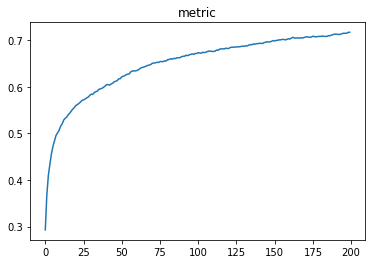

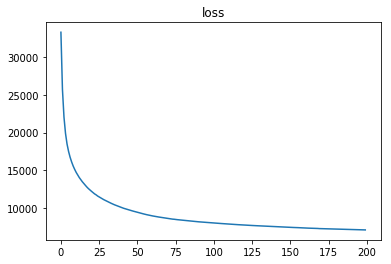

In [56]:
nn = NeuralNet(epochs=200, batch_size=1000, lr_decay_rate=1e-3, lr=.2)#3000, 2, 3e-4, 100)

nn.add(InputLayer())
nn.add(Dense(32))
nn.add(Tanh())
nn.add(Dropout(.2))
nn.add(Dense(5))
nn.add(SoftMaxCrossEntropy())
       
history = nn.fit(X_train, y_train.reshape(-1, 1))  
result = nn.predict(X_test)

print(accuracy_score(result, y_test))

plt.plot(history['metric'])
plt.title('metric')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.show()

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.811


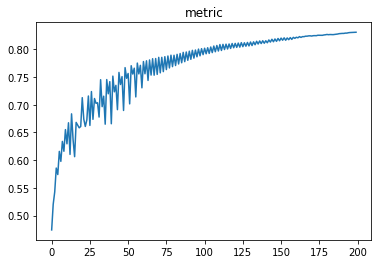

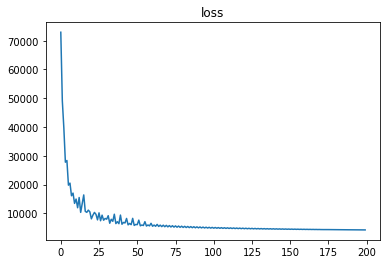

In [57]:
nn = NeuralNet(epochs=200, batch_size=1000, lr_decay_rate=1e-3, lr=.2)#3000, 2, 3e-4, 100)

nn.add(InputLayer())
nn.add(Dense(32))
nn.add(SoftPlus())
nn.add(Dense(5))
nn.add(SoftMaxCrossEntropy())
       
history = nn.fit(X_train, y_train.reshape(-1, 1))  
result = nn.predict(X_test)

print(accuracy_score(result, y_test))

plt.plot(history['metric'])
plt.title('metric')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.show()

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.829


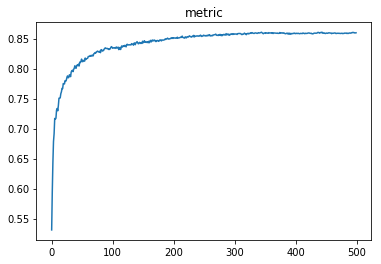

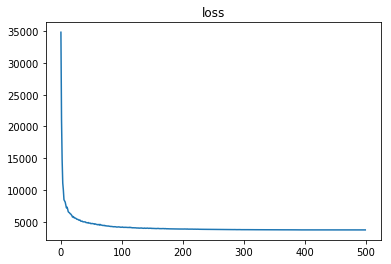

In [58]:
nn = NeuralNet(epochs=500, batch_size=250, lr_decay_rate=1e-2, lr=.2)#3000, 2, 3e-4, 100)

nn.add(InputLayer())
nn.add(Dense(32))
nn.add(ReLU())
nn.add(Dropout(.1))
nn.add(Dense(5))
nn.add(SoftMaxCrossEntropy())
       
history = nn.fit(X_train, y_train.reshape(-1, 1))  
result = nn.predict(X_test)

print(accuracy_score(result, y_test))

plt.plot(history['metric'])
plt.title('metric')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.show()

# MNIST

In [59]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [60]:
X = read_idx('./mnist/train-images.idx3-ubyte')
y = read_idx('./mnist/train-labels.idx1-ubyte')

D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


In [61]:
X = X.reshape(60000, -1)
y = y.reshape(-1, 1)

In [62]:
X = X / 255

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

## Пробуем с Dropout

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.9405


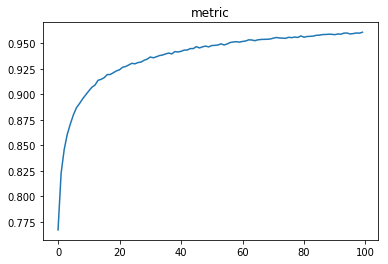

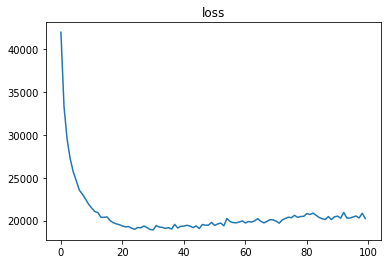

In [73]:
nn = NeuralNet(epochs=100, batch_size=500, lr=1, lr_decay_rate=1e-2)#3000, 2, 3e-4, 100)

nn.add(InputLayer())
nn.add(Dense(32))
nn.add(Tanh())
nn.add(Dropout(.2))
nn.add(Dense(10))
nn.add(SoftMaxCrossEntropy())
       
history = nn.fit(X_train, y_train.reshape(-1, 1))  
result = nn.predict(X_test)

print(accuracy_score(result, y_test))

plt.plot(history['metric'])
plt.title('metric')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.show()

## Пробуем без Dropout

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.9265


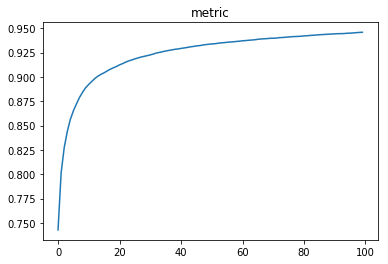

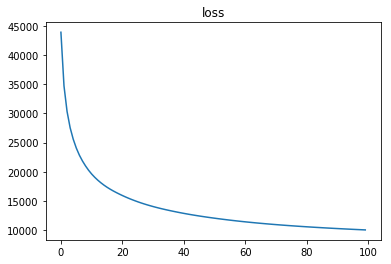

In [74]:
nn = NeuralNet(epochs=100, batch_size=500, lr=1, lr_decay_rate=1e-2)#3000, 2, 3e-4, 100)

nn.add(InputLayer())
nn.add(Dense(32))
nn.add(Tanh())
nn.add(Dense(10))
nn.add(SoftMaxCrossEntropy())

       
history = nn.fit(X_train, y_train.reshape(-1, 1))  
result = nn.predict(X_test)

print(accuracy_score(result, y_test))

plt.plot(history['metric'])
plt.title('metric')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.show()

# Регрессия на синтетике

In [20]:
X, y = make_regression(n_informative=10, n_samples=10000)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

7447.4323531833215


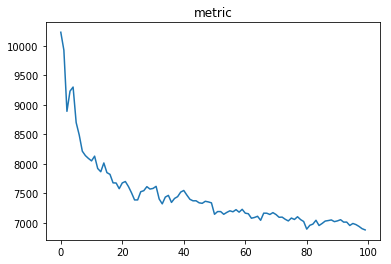

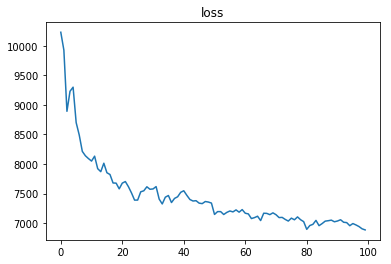

In [22]:
nn = NeuralNet(epochs=100, batch_size=1000, lr=.3, lr_decay_rate=5e-3, loss='mse', metric='mse')

nn.add(InputLayer())
nn.add(Dense(4))
nn.add(Tanh())
nn.add(Dense(1))
nn.add(LinearMSE())
       
history = nn.fit(X_train, y_train.reshape(-1, 1))  
result = nn.predict(X_test)

print(mean_squared_error(result, y_test))

plt.plot(history['metric'])
plt.title('metric')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.show()

0.08567114399037237


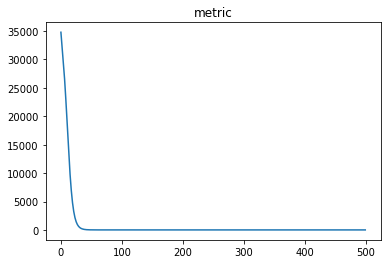

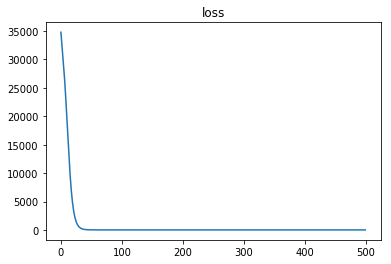

In [23]:
nn = NeuralNet(epochs=500, batch_size=2000, lr=1e-4, lr_decay_rate=2e-3, loss='mse', metric='mse')

nn.add(InputLayer())
nn.add(Dense(16))
nn.add(Dense(4))
nn.add(Dense(1))
nn.add(LinearMSE())
       
history = nn.fit(X_train, y_train.reshape(-1, 1))  
result = nn.predict(X_test)

print(mean_squared_error(result, y_test))

plt.plot(history['metric'])
plt.title('metric')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.show()

0.08567114399037237


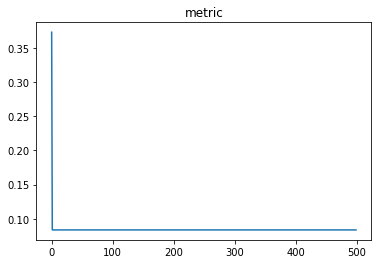

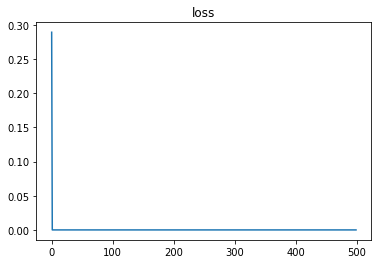

In [24]:
nn = NeuralNet(epochs=500, batch_size=2000, lr=1, lr_decay_rate=2e-3, loss='mse', metric='mse')

nn.add(InputLayer())
nn.add(Dense(1))
nn.add(LinearMSE())
       
history = nn.fit(X_train, y_train.reshape(-1, 1))  
result = nn.predict(X_test)

print(mean_squared_error(result, y_test))

plt.plot(history['metric'])
plt.title('metric')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.show()